# Ringmaps and Maps Tutorial

This tutorial will go over how to load a ringmap file, and how to interpret it's contents. As bonus material it goes over how to read a Healpix formatted map files.

## Setup

In [1]:
# The following line ensures high resolution plots on HiDPI screens
%config InlineBackend.figure_format='retina'
%matplotlib inline

import h5py

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patheffects

import numpy as np

from draco.core import containers
from ch_util import ephemeris

## Loading data

Before loading the data you'll need to make sure that you have downloaded it from the CHIME web server. You can fetch it via `curl` on the command line with

```bash
curl -O https://bao.chimenet.ca/analysis_tutorial/ringmap_reduced.h5
curl -O https://bao.chimenet.ca/analysis_tutorial/map_galaxy_reduced.h5
```

CHIME data is based around what we term *containers*, objects holding a structured set of data of a specific type (such as a `Map`, or a `SiderealStream`). When on disk they are typically stored in [HDF5](https://www.hdf5.org/) files organised in a standardised format. These can be read directly with the excellent Python library [h5py](https:///www.h5py.org).

In [2]:
# Load an HDF5 file directly and print out a summary of the map dataset
with h5py.File("ringmap_reduced.h5", "r") as fh:
    print(fh)
    print(fh["map"])

<HDF5 file "ringmap_reduced.h5" (mode r)>
<HDF5 dataset "map": shape (1, 2, 16, 4096, 1024), type "<f8">


*However* it is generally much better to use the specific CHIME tools to do so, which will load the data into the standard in-memory container format. To do this you can simply do:

In [3]:
ringmap = containers.RingMap.from_file("ringmap_reduced.h5")

Note, that this will load the *entire* file into memory and this file is quite large (3.5 GB), in a later section we'll cover how to load subsets of the data in a file.

In [4]:
print(ringmap)
print(ringmap["map"])

<memh5 common dataset '/map': shape (1, 2, 16, 4096, 1024), type "dtype('<f8')">


Notice the similarity between this and the output from directly loading with h5py. This is because CHIME containers are implemented using `caput.memh5` a module for holding structured data in memory inspired by the `h5py` API.

## Understanding the data

CHIME data containers all use a common API and set of conventions. A container holds a series of *datasets*, where each dataset is a multidimensional array of a fixed data type. We accessed one of the datasets above with `ringmap["map"]`, which is the most generic way of accessing datasets, however in many cases the  key datasets for each container have specific properties for accessing them. For instance ringmaps have `.map` property which is an alias for `ringmap["map"]` , using this alias is recommended.

In [5]:
print(ringmap.map)
print(ringmap["map"])

<memh5 common dataset '/map': shape (1, 2, 16, 4096, 1024), type "dtype('<f8')">
<memh5 common dataset '/map': shape (1, 2, 16, 4096, 1024), type "dtype('<f8')">


To find out what datasets are present in a container you can simply list them as you would a Python `dict`

In [6]:
for name, dset in ringmap.items():
    print(f"{name:10s}: {dset}")

dirty_beam: <memh5 common dataset '/dirty_beam': shape (1, 2, 16, 4096, 1024), type "dtype('<f8')">
map       : <memh5 common dataset '/map': shape (1, 2, 16, 4096, 1024), type "dtype('<f8')">
rms       : <memh5 common dataset '/rms': shape (2, 16, 4096), type "dtype('<f8')">
weight    : <memh5 common dataset '/weight': shape (2, 16, 4096, 1024), type "dtype('<f8')">


Underneath a dataset is simply a numpy array which can be accessed by any *slice* of the dataset (including a simple `:` slice). The numpy array is the same size and datatype as the dataset indicates

In [7]:
ringmap.map[:].shape

(1, 2, 16, 4096, 1024)

In [8]:
ringmap.map[:].dtype

dtype('<f8')

The data can be accessed in the same way as numpy array

In [9]:
ringmap.map[0, 0, 3, 0, :5]

array([3.66283754, 3.84887681, 3.59326996, 3.70586787, 4.08164265])

Okay, so now we know how to access the data, but what actually is it?? CHIME containers are intended to be self-describing with all the information to interpret them included within the containers. Let us take the `.map` dataset for instance, we have seen above that it is a 5D array, but what are each of those dimensions?

In any CHIME container to find what each dimension of the array means you can look it up in the `axis` attribute of that dataset, accessed by the `.attrs` property. 

In [10]:
ringmap.map.attrs["axis"]

array(['beam', 'pol', 'freq', 'ra', 'el'], dtype=object)

This shows us that the `map` dataset has five axes, with each having the listed name, and each mapping in order to the axis of the dataset. Using this we can map the axis name to a length in the dataset

In [11]:
for name, length in zip(ringmap.map.attrs["axis"], ringmap.map.shape):
    print(name, length)

beam 1
pol 2
freq 16
ra 4096
el 1024


So the `beam` axis is length 1, the `freq` axis length 16, etc...

That's the first part of the description, we now have a mapping from each dimension of an array to a specific named axis. The second part is to understand what each position along an axis means. That is described in the `.index_map` for each container. Each named axis is guaranteed to have an entry in the `.index_map` describing what each position corresponds to.

Let us take the frequency axis for instance

In [12]:
ringmap.index_map["freq"]

array([(800.      , 0.390625), (799.609375, 0.390625),
       (799.21875 , 0.390625), (798.828125, 0.390625),
       (798.4375  , 0.390625), (798.046875, 0.390625),
       (797.65625 , 0.390625), (797.265625, 0.390625),
       (796.875   , 0.390625), (796.484375, 0.390625),
       (796.09375 , 0.390625), (795.703125, 0.390625),
       (795.3125  , 0.390625), (794.921875, 0.390625),
       (794.53125 , 0.390625), (794.140625, 0.390625)],
      dtype=[('centre', '<f8'), ('width', '<f8')])

Each entry describes the frequency channels being represented, giving the central frequency and width of each channel (both in MHz).

Let's quickly go over the other axes, first the `beam` axis

In [13]:
ringmap.index_map["beam"]

array([0])

This one isn't very interesting. Ringmaps can either contain a single "beam", or a series of beams offset in the East-West direction. For CHIME there are up to 7 of these, but most ringmaps contain just a single pointing for the central beam. Even with a grid of E-W beams, the central beam is always at index 0.

The next axis (`pol`) is a little more interesting...

In [14]:
ringmap.index_map["pol"]

array(['XX', 'YY'], dtype='<U4')

This describes the polarisation combinations available in the map. Generally maps have polarisations of three types:
- Beam polarisation: this is the raw dipole polarisation combinations. CHIME has dipoles in two directions, X and Y, and the polarisations are the correlations of these. So XX is the correlation of the X polarisation direction with itself, same for YY (these are referred to a *co-polar*), where as XY would be the cross correlation of the X and Y dipole directions (*cross-polar*). Note that YX is not the same as XY (typically differs by complex conjugation).
- Real beam polarisations: often used for maps these are similar to the above, but rather than XY and YX, the polarisations are `reXY` (i.e. real(XY)) and `imXY` (i.e. imag(XY)).
- Stokes polarisations: typically used in simulated maps, or the final stages of some analyses, these are the usual Stokes parameters I, Q, U and V.

As we can see the ringmap above contains a subset of the beam polarisations, just the dipole co-pol combinations XX and YY.

Next up is the `ra` axis...

In [15]:
ringmap.index_map["ra"][:10]

array([0.        , 0.08789062, 0.17578125, 0.26367188, 0.3515625 ,
       0.43945312, 0.52734375, 0.61523438, 0.703125  , 0.79101562])

This is the transiting right ascension (RA) for each sample in *degrees*. This is the centre of each finite width sample.

The final axis is `el`...

In [16]:
ringmap.index_map["el"][:10]

array([-1.        , -0.99804497, -0.99608993, -0.9941349 , -0.99217986,
       -0.99022483, -0.98826979, -0.98631476, -0.98435973, -0.98240469])

This describes the location of each pixel of the map in the declination direction. It is given as the sine of the angle from zenith along the meridian (i.e. the north-south axis) passing through the zenith. It can be crudely mapped to a declination by:

In [17]:
from ch_util import tools

chime_lat, _ = tools._LAT_LON["chime"]

dec = chime_lat + np.degrees(np.arcsin(ringmap.index_map["el"]))

In [18]:
print(dec[:10])

[-40.6792875  -37.09596752 -35.61088122 -34.47076968 -33.50913762
 -32.66150586 -31.89481106 -31.1894153  -30.53252547 -29.91525685]


Some of the axes are used so commonly they have handy aliases. For ringmaps the three axes of note are, the `pol`, `ra` and `freq` ones

In [19]:
ringmap.ra[:10]

array([0.        , 0.08789062, 0.17578125, 0.26367188, 0.3515625 ,
       0.43945312, 0.52734375, 0.61523438, 0.703125  , 0.79101562])

In [20]:
ringmap.pol

array(['XX', 'YY'], dtype='<U4')

In [21]:
ringmap.freq

array([800.      , 799.609375, 799.21875 , 798.828125, 798.4375  ,
       798.046875, 797.65625 , 797.265625, 796.875   , 796.484375,
       796.09375 , 795.703125, 795.3125  , 794.921875, 794.53125 ,
       794.140625])

Note that the `freq` axis only returns the `centre` component giving the central frequency in MHz of the element.

## Plotting a ringmap

We now have everything we need to plot a ring map.

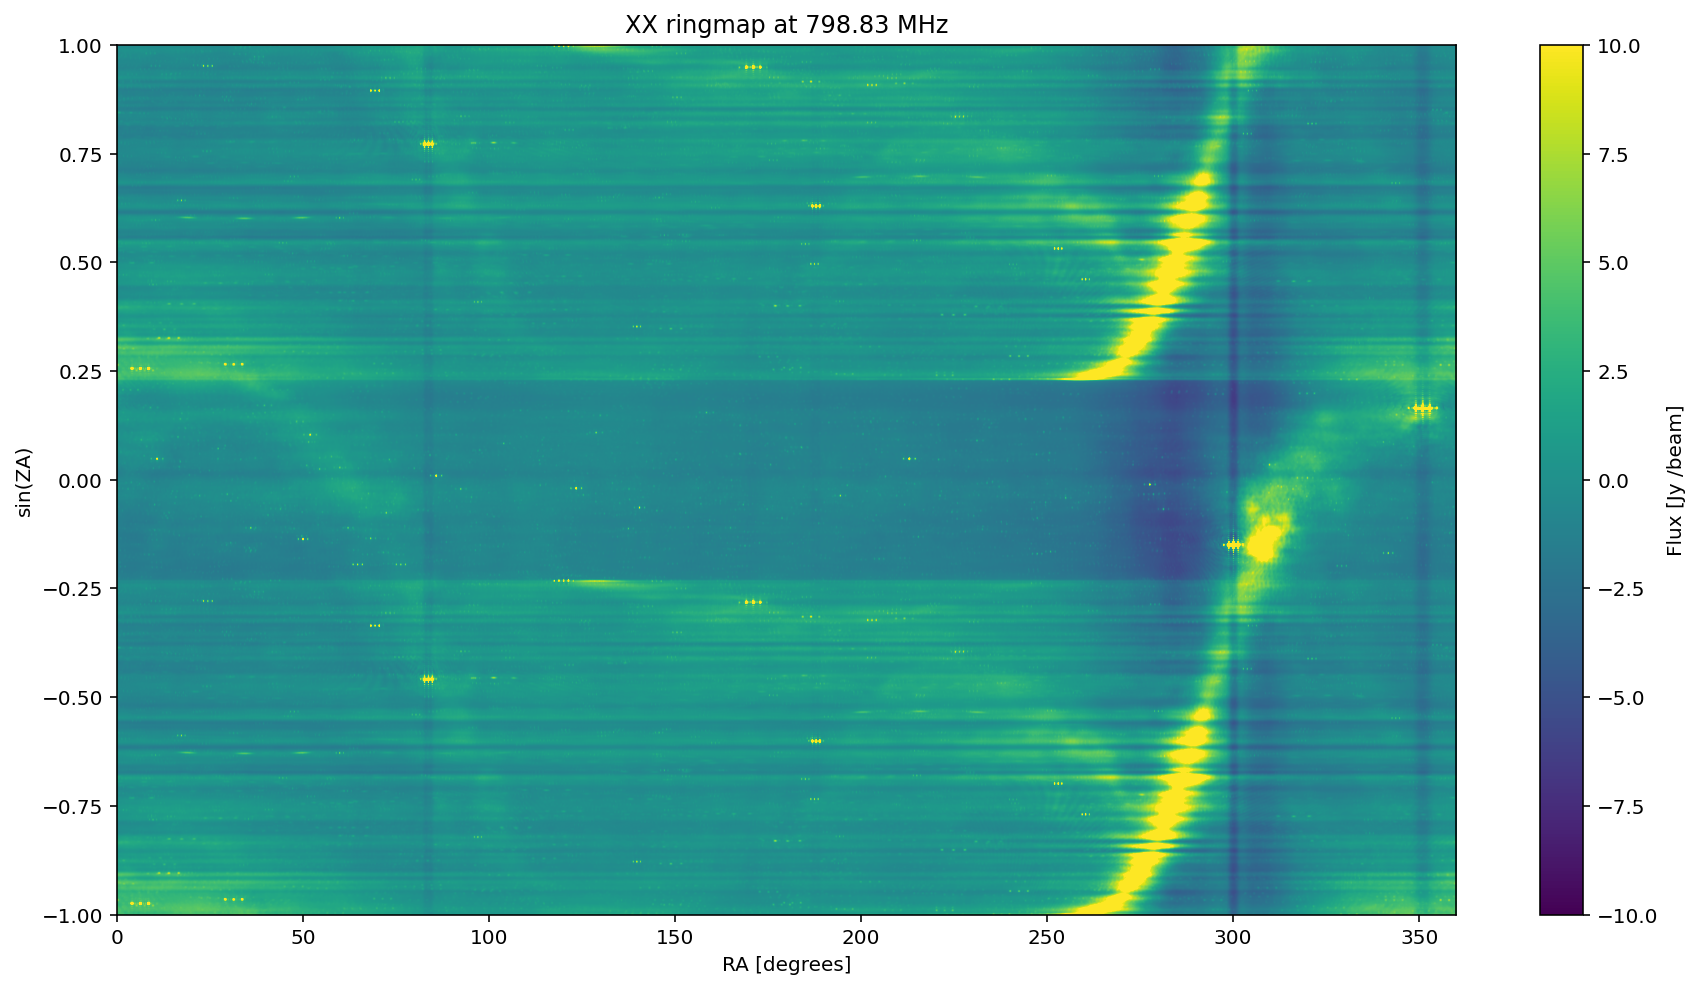

In [22]:
freq_ind = 3
pol_ind = 0

fig, axis = plt.subplots(1, 1, figsize=(15, 8))
im = axis.imshow(
    ringmap.map[0, pol_ind, freq_ind].T,
    extent=(ringmap.ra[0], ringmap.ra[-1], -1, 1),
    origin="lower",
    vmin=-10,
    vmax=10,
    aspect="auto"
)

axis.set_title(f"{ringmap.pol[pol_ind]} ringmap at {ringmap.freq[freq_ind]:.2f} MHz")
axis.set_xlabel("RA [degrees]")
axis.set_ylabel("sin(ZA)")

cb = fig.colorbar(im)
cb.set_label("Flux [Jy /beam]")

## Destriping

In the maps above there is very obvious horizontal striping. This is because these maps usually remove the average of the time direction. To make them look smoother it is useful to remove this striping by referencing each declination strip in the same way. A good way to do this is to set the median of each strip to zero.

In [23]:
def destripe(m):
    med = np.median(m, axis=1)
    return m - med[:, np.newaxis]

NameError: name 'sza2dec' is not defined

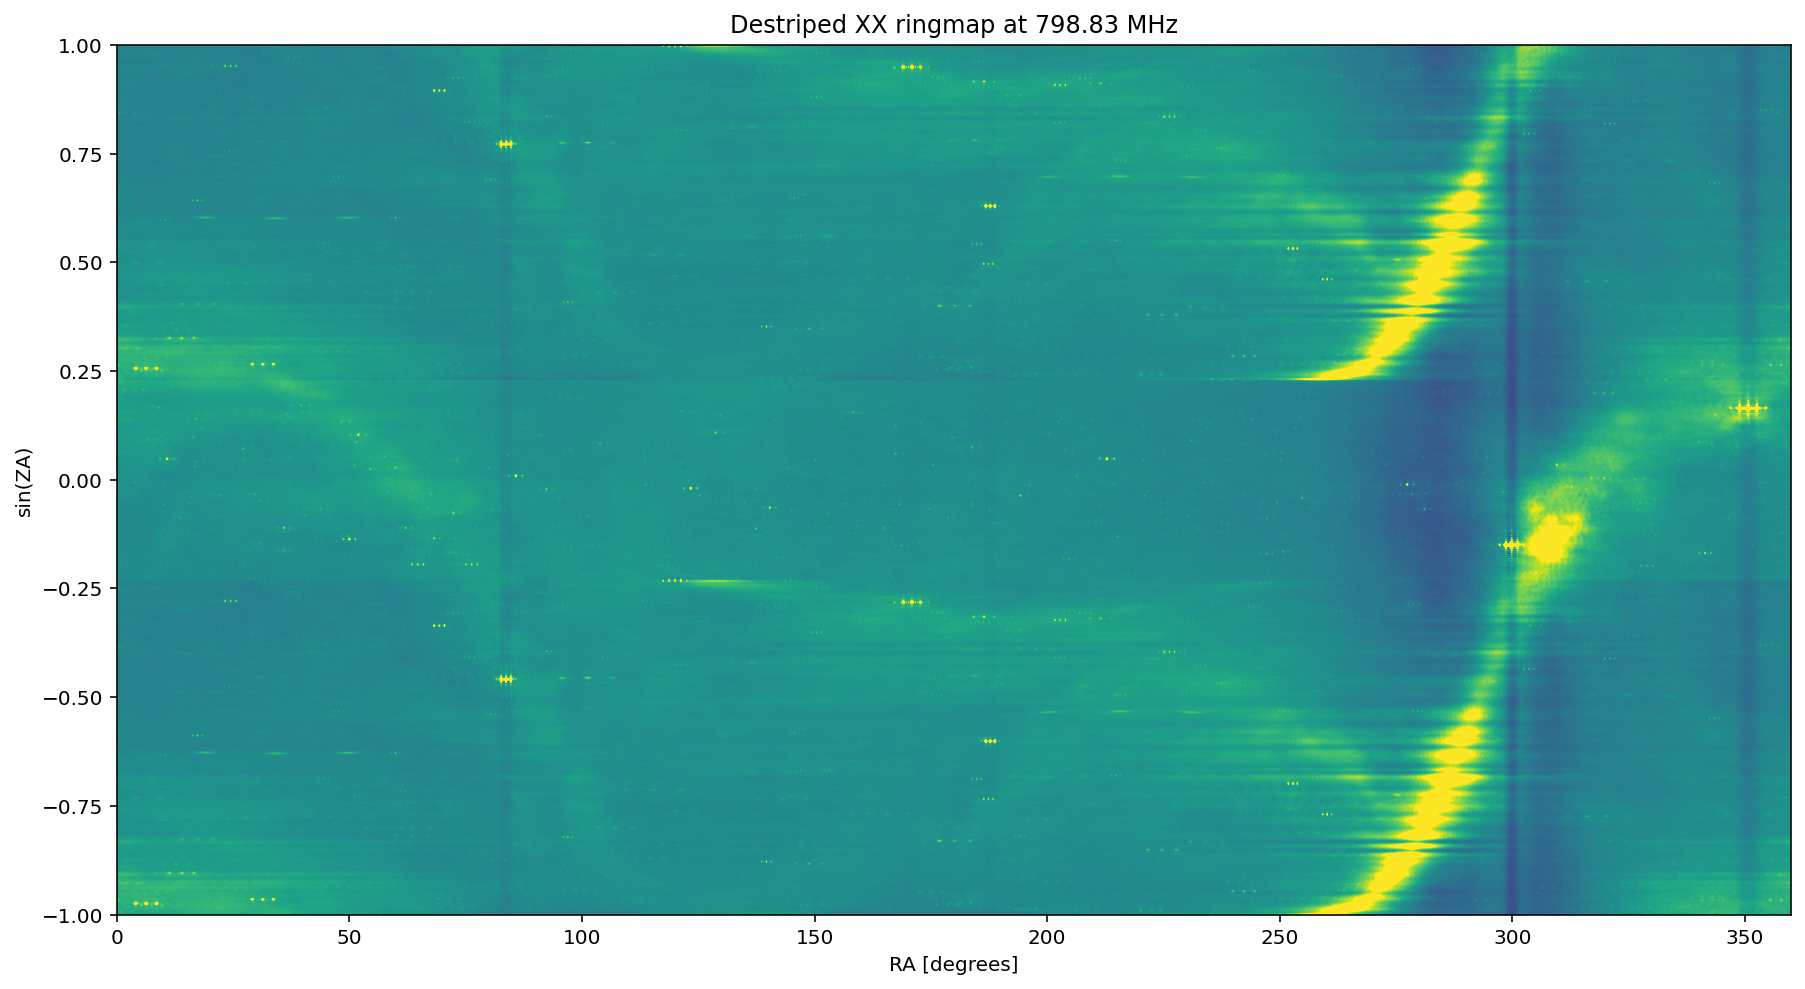

In [24]:
fig, axis = plt.subplots(1, 1, figsize=(15, 8))
im = axis.imshow(
    destripe(ringmap.map[0, pol_ind, freq_ind].T.copy()),
    extent=(ringmap.ra[0], ringmap.ra[-1], -1, 1),
    origin="lower",
    vmin=-10,
    vmax=10,
    aspect="auto"
)

axis.set_title(f"Destriped {ringmap.pol[pol_ind]} ringmap at {ringmap.freq[freq_ind]:.2f} MHz")
axis.set_xlabel("RA [degrees]")
axis.set_ylabel("sin(ZA)")

# Plot a secondary axis showing the declination
secax = axis.secondary_yaxis("right", functions=(sza2dec, dec2sza))
secax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
secax.set_ylabel("Declination [degrees]")
secax.set_yticks([-30.0, 0, 30.0, 60, 90, 120])

cb = fig.colorbar(im)
cb.set_label("Flux [Jy /beam]")

## Interpreting the ring map

This ringmap has a bunch of interesting features in it, and in the plot below we try and highlight some of them. This gives an example of how to do some of the coordinate transformations and how to use some of the other features of the CHIME code libraries.

This will:
- Add a declination axis
- Plot the location of the galactic plane
- Calculate and plot the location of the *alias* of the galactic plane (caused by the fact the shortest baseline spacing in CHIME, 0.3048m, is longer than half the wavelength at the upper end of our band).
- Plot the location of bright point sources in the maps

In [ ]:
# Calculate the coordinates of the galactic plane
#  https://en.wikipedia.org/wiki/Galactic_coordinate_system
ngp_ra = (12.0 + 51.4 / 60.0) * 15.0
ngp_dec = 27.13

dl = np.linspace(0, 2 * np.pi, 1024)
gal_dec = np.degrees(np.arcsin(np.cos(np.radians(ngp_dec)) * np.cos(dl)))
gal_ra = np.degrees(np.arctan2(
    np.sin(dl) / np.cos(np.radians(gal_dec)),
    -np.sin(np.radians(ngp_dec)) * np.cos(dl) / np.cos(np.radians(gal_dec)),
)) + ngp_ra

# Rotate the entries to ensure that there is no jump
gal_ra = gal_ra % 360.0
wrap_ind = np.argmax(np.diff(gal_ra))
gal_ra = np.roll(gal_ra, -(wrap_ind + 1))
gal_dec = np.roll(gal_dec, -(wrap_ind + 1))

In [ ]:
# Define forward and inverse transforms from dec to sin(za), these are needed to generate the secondary axis
def dec2sza(dec):
    za = np.radians(dec - tools._LAT_LON["chime"][0])
    # Clamp the output at the boundaries when the declination is outside the
    # observable range
    return np.where(np.abs(za) > np.pi / 2, np.sign(za), np.sin(za))

def sza2dec(sza):
    return tools._LAT_LON["chime"][0] + np.degrees(np.arcsin(sza))

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(15, 8))
im = axis.imshow(
    destripe(ringmap.map[0, pol_ind, freq_ind].T.copy()),
    extent=(ringmap.ra[0], ringmap.ra[-1], -1, 1),
    origin="lower",
    vmin=-10,
    vmax=10,
    aspect="auto"
)

axis.set_title(f"Destriped {ringmap.pol[pol_ind]} ringmap at {ringmap.freq[freq_ind]:.2f} MHz")
axis.set_xlabel("RA [degrees]")
axis.set_ylabel("sin(ZA)")

# Plot a secondary axis showing the declination
secax = axis.secondary_yaxis("right", functions=(sza2dec, dec2sza))
secax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
secax.set_ylabel("Declination [degrees]")
secax.set_yticks([-30.0, 0, 30.0, 60, 90, 120])

# Plot the path of the galactic plane, we need to massage the sza to make it dissappear
# when it leaves the observable range
gal_sza = dec2sza(gal_dec)
gal_sza = np.where(np.abs(gal_sza) >= 1.0, np.nan, gal_sza)
axis.plot(gal_ra, gal_sza, color="r", label="Galactic plane")

# Plot the path of the aliased galactic plane at this frequency and feed spacing.
# Again we need to massage the sza to make it dissappear when it leaves the observable range
alias_sza = gal_sza + 3e2 / ringmap.freq[freq_ind] / 0.3048
alias_sza = np.where(np.abs(alias_sza) >= 1.0, np.nan, alias_sza)
axis.plot(gal_ra, alias_sza, color="r", ls="--", label="Galactic plane alias")

# Plot known bright sources on the sky
for ii, srcname in enumerate(["CYG_A", "CAS_A", "TAU_A", "VIR_A"]):
    
    # Get the RA, DEC coordinates of a named source
    ra, dec = ephemeris.object_coords(ephemeris.source_dictionary[srcname], deg=True)
    
    # Plot a circle around the source and make it stand out by putting a white outline around it
    circ = axis.plot(ra, dec2sza(dec), ls="", markeredgecolor=f"C{ii}", marker="o", ms=12, markerfacecolor="none", label=srcname, markeredgewidth=2)
    circ[0].set_path_effects([patheffects.Stroke(linewidth=3, foreground='w'),
                       patheffects.Normal()])

axis.legend()

cb = fig.colorbar(im)
cb.set_label("Flux [Jy /beam]")

## Weights

Most container types for CHIME carry with them a *weight* dataset which gives an estimate of how noisy the data is. This is conventionally the *inverse variance* of the piece of the data it is referring to, but we will need to look precisely to see what data it is referring to.

For the ringmaps, the map dataset has shape and axes

In [ ]:
for name, length in zip(ringmap.map.attrs["axis"], ringmap.map.shape):
    print(name, length)

whereas the weight dataset has shape

In [ ]:
for name, length in zip(ringmap.weight.attrs["axis"], ringmap.weight.shape):
    print(name, length)

We can see clearly that the weight dataset *does not* have a beam axis. In this case it is because *all* beams have the same noise and thus the same weight estimate.

As the weights are defined as being estimates of the inverse variance of the pixels in the maps, if data is missing, it effectively has infinite noise, and thus zero weights. So zero weights act as a mask that indicates missing data. This simulated data has missing frequencies (corresponding to RFI dominated frequencies in actual CHIME data). We can see that by plotting the weights as a function of frequency index.

In [ ]:
plt.plot(ringmap.weight[0, :].mean(axis=(1, 2)) > 0)
plt.xlabel("Frequency index")

## Coordinate Issues

There are some issues to be aware of in the coordinates that CHIME observes in. CHIME is a transit telescope and observes in a frame defined by the Earth's polar axis. Unfortunately as this axis precesses the coordinates of pixels in a daily ringmap will correspond to slightly different places in the actual sky, which could be around a pixel shift across the life time of CHIME.

This is a complex issue, described in detail in [USNO Circular 179](http://arxiv.org/abs/astro-ph/0602086), but for CHIME we need to worry about two coordinate frames:
- *ICRS* coordinates: these are fixed coordinates on the sky independent of the Earth's polar axis. When given in RA, DEC they essentially correspond to J2000 coordinates. Note that for most bodies these coordinates do not really change with time, the exceptions being things in our solar system, e.g. the sun, planets and the moon.
- *CIRS* coordinates: these are coordinates in a frame aligned with the Earth's current polar axis which have been minimally rotate with time. They are time dependent, i.e. you must give an epoch for when they are valid, and so the coordinates of a fixed source will change slightly in CIRS coordinates as the time/epoch changes.

CHIME observes in CIRS coordinates (that is what each daily map is in), but quoted positions in catalogs etc, will be in ICRS coordinates and so you will need to map between the two of them. The routine `ch_util.ephemeris.object_coords` can help with this, as can `draco.analysis.beamform.icrs_to_cirs`. The epoch of observation is usually given by the CSD (CHIME Sidereal Day), which can be converted into other time formats using `ephemeris.csd_to_unix` and related routines.

The ringmap we have been working with above was simulated and so did not have an observation epoch set. In this case it is assumed to have been observed at the J2000 epoch (i.e. Jan 1st, 2000), or equivalently be in ICRS coordinates.